# Detect Noisy channels

In [1]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
subject = 617
# Add the workspace root to the Python path
workspace_root = os.path.abspath("../..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)
from functions import preprocess

# Load the bridged channels data
with open(os.path.join(workspace_root, 'Data', 'bridged_channels_analysis.pkl'), "rb") as f:
    all_bridged_channels = pickle.load(f)
    bridged_channels= all_bridged_channels[subject] # either 5 or 16 ; 16 is a stricter threshold

print('Bridged channels:', bridged_channels['bridged_ch_names'])
mne.set_log_level('ERROR')
sub = preprocess(subject)
raw = sub.load_data()
raw.notch_filter(50, fir_design='firwin', skip_by_annotation='edge')
raw.filter(l_freq=1, h_freq= 30)

Bridged channels: ['A2', 'A3', 'A6', 'A14', 'A15', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A26', 'A27', 'A31', 'A32', 'B23', 'B24', 'B29', 'B30', 'C3', 'C4', 'C6', 'C7', 'C9', 'C10', 'C14', 'C15', 'C16', 'C18', 'C19', 'C20', 'C22', 'C23', 'C25', 'C26', 'C28', 'C29', 'C30', 'C31', 'D10', 'D11', 'D17', 'D22', 'D23', 'D28', 'D29', 'D30']


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


<RawEDF | O_617_Def_OF.bdf, 129 x 455168 (889.0 s), ~448.1 MiB, data loaded>

In [2]:
events = mne.find_events(raw)
bad_trials=[]
all_events = sub.get_all_events_times(events).dropna()
Stim_RT_data = sub.segment_stimRt(raw, all_events, bad_trials)

In [3]:
from pyprep.find_noisy_channels import NoisyChannels
det = NoisyChannels(Stim_RT_data, do_detrend=False)
det.find_all_bads(ransac=False)
bad_ch = det.get_bads(as_dict=True)
bad_ch

{'bad_by_nan': [],
 'bad_by_flat': [],
 'bad_by_deviation': [],
 'bad_by_hf_noise': ['A16', 'A31', 'A32', 'C28', 'C29'],
 'bad_by_correlation': ['A5',
  'A8',
  'A12',
  'A31',
  'A32',
  'B6',
  'B10',
  'B22',
  'D5',
  'D9',
  'D18',
  'D20',
  'D25',
  'D27'],
 'bad_by_SNR': ['A32', 'A31'],
 'bad_by_dropout': [],
 'bad_by_ransac': [],
 'bad_all': ['B10',
  'B22',
  'A32',
  'D18',
  'D20',
  'A31',
  'A8',
  'A16',
  'B6',
  'D5',
  'D9',
  'A12',
  'C29',
  'A5',
  'D25',
  'C28',
  'D27']}

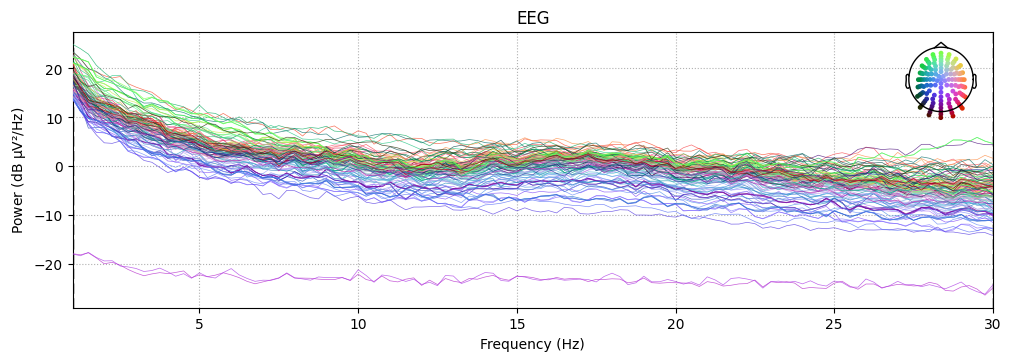

In [4]:
%matplotlib qt
Stim_RT_data.plot_psd(fmin = 1, fmax = 30)

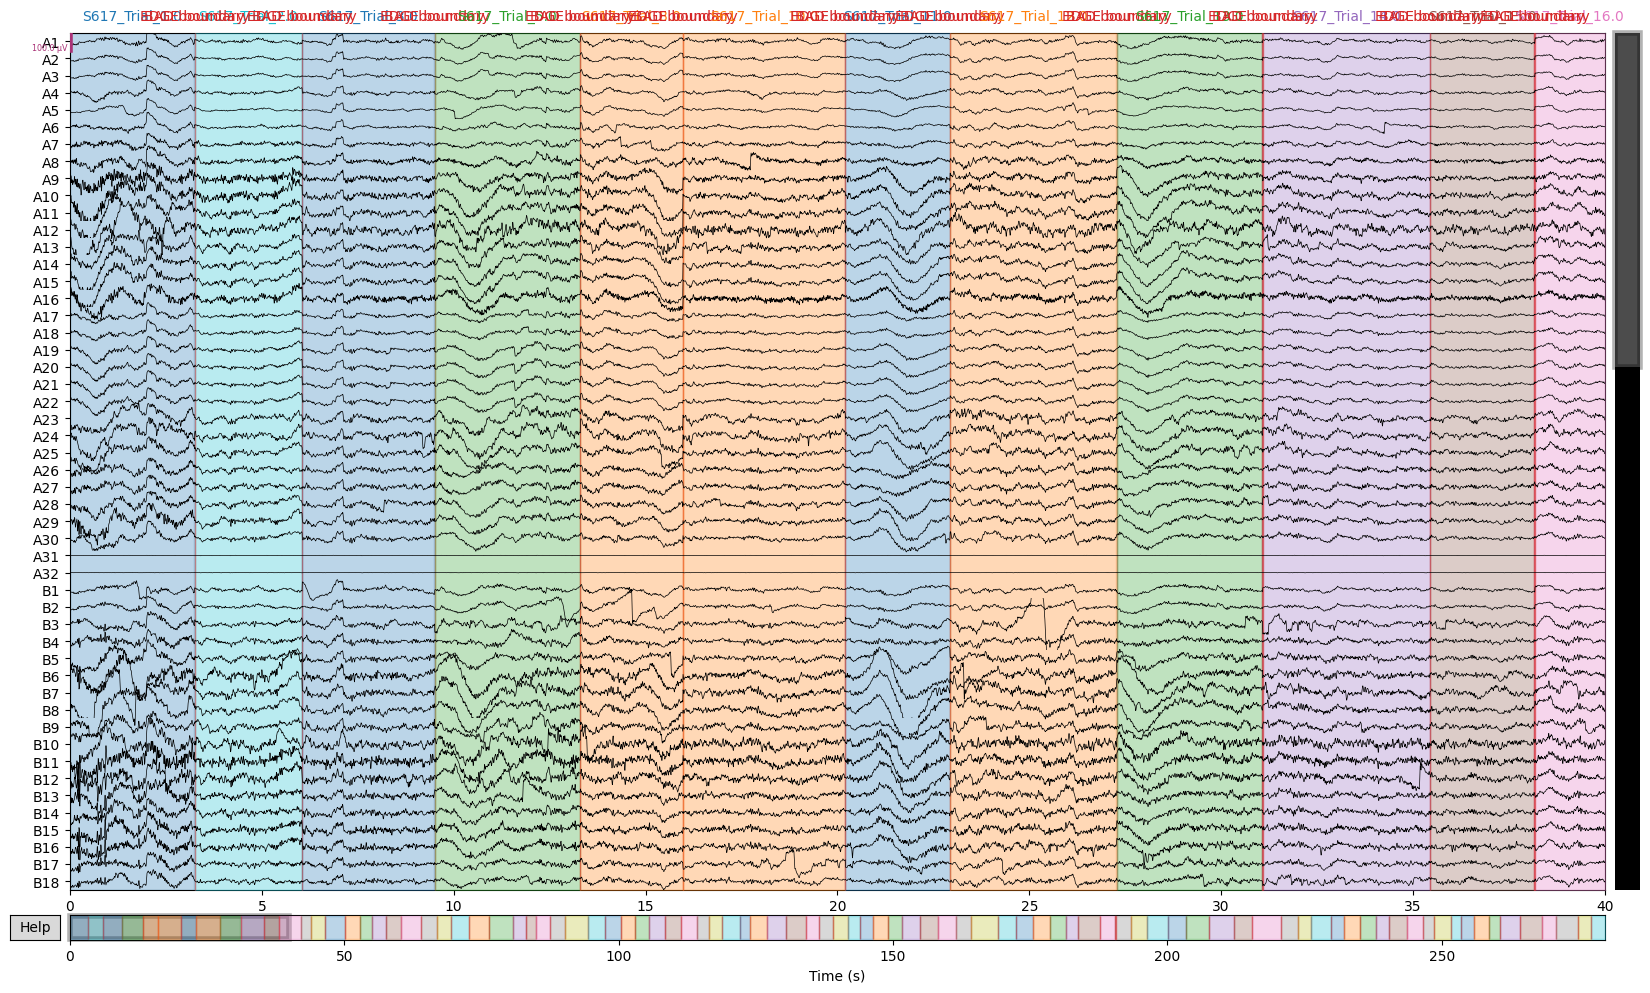

In [6]:
%matplotlib qt 
Stim_RT_data.resample(256)
Stim_RT_data.plot( n_channels=50, scalings=dict(eeg=50e-6), picks = 'eeg', duration = 40)


# find noisy Trials

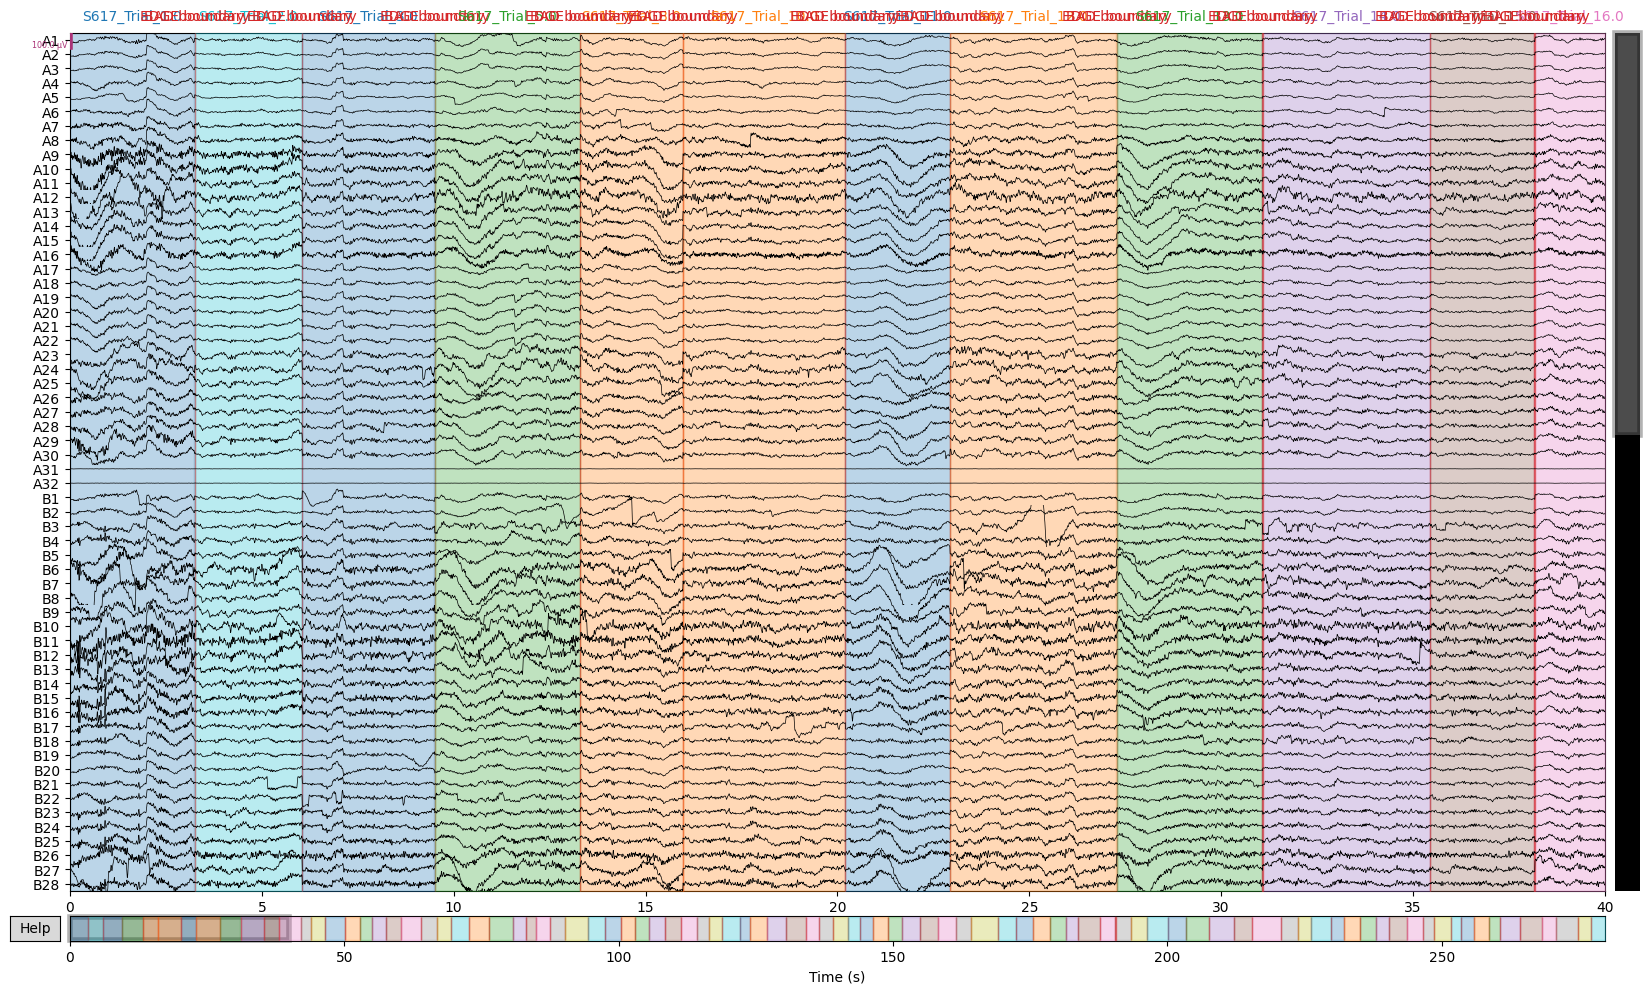

In [8]:
%matplotlib qt 
Stim_RT_data.plot( n_channels=60, scalings=dict(eeg=50e-6), picks = 'eeg', duration = 40)


In [9]:
# load the selected bad channels
with open(os.path.join(workspace_root, 'Data', 'bad_channels_detected.pkl'), "rb") as f:
    detected_noise = pickle.load(f)
detected_noise[subject] = {'channel_names': ['A31','A32','A16','D25','B10','D9','D5'],
                           'trial_numbers': [1,5,8,11,13]}
# save the selected bad channels
with open(os.path.join(workspace_root, 'Data', 'bad_channels_detected.pkl'), "wb") as f:
    pickle.dump(detected_noise, f)